## Project 10

**Mohammad Kamal Sadeghabadi Farahani**

### Description

In this project we have used the mechanisms of K-Winners-Take-All and lateral inhibition to extract some features from a set of images of faces, first we will pass the image from a DoG filter and then using Time2FirstSpike encoder will turn it to spike trains, then we will use K-Winners-Take-All and lateral inhibition and STDP to extract features.

In [1]:
import torch
import random
import sys
import copy
import matplotlib.pyplot as plt
import numpy as np

from time import sleep
from typing import List, Callable
from PIL import Image

sys.path.insert(0, '../../')

from cnsproject.plotting.plotting import raster_plot, plot_position_encoder_result, plot_weights, plot_dopamin
from cnsproject.encoding.encoders import PoissonEncoder, Time2FirstSpikeEncoder
from cnsproject.network.neural_populations import InputPopulation, LIFPopulation
from cnsproject.network.connections import DenseConnection, ConvolutionalConnection, PoolingConnection, calculate_pooling_post_population_size
from cnsproject.learning.learning_rules import STDP, RSTDP, FlatRSTDP, WinnerSTDP
from cnsproject.learning.rewards import SimpleReward
from cnsproject.network.network import Network
from cnsproject.imagetools.filters import make_gaussian_filter, DoG, gabor, convolve
from cnsproject.decision.decision import WinnerTakeAllDecision

### Dataset

we will use the following images as our dataset

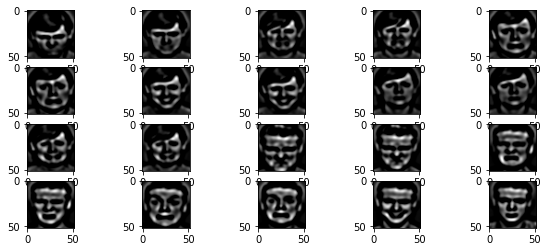

In [2]:
images = []
for i in range(1, 21):
    images.append(Image.open(f'./images/{i}.jpg'))

img_size = (64, 64)
images_tensors = [torch.tensor(np.asarray(img.convert('RGB').convert('L').resize(img_size))) for img in images]
kernel = DoG(std_1=3, std_2=5, size=13)

imgs_convs = [convolve(img_tensor, kernel) for img_tensor in images_tensors]

time = 0.05
dt = 0.001

fig = plt.figure(figsize=(10, 4))
rows = 4
columns = 5

for img in imgs_convs:
    img.clamp_(0, 255)

for idx, img in enumerate(imgs_convs):
    fig.add_subplot(rows, columns, idx + 1)
    plt.imshow(img, cmap='gray')

In [3]:
def extract_features(features_number, feature_size, lr):
    features = torch.rand(features_number, feature_size, feature_size) * 0.2 + 0.1
    
    print('Before extraction:')
    for idx, feature in enumerate(features):
        print(f'feature {idx + 1}')
        plt.imshow(feature, cmap='gray')
        plt.show()
    
    for img_conv in imgs_convs:
        encoder = Time2FirstSpikeEncoder(time, dt)
        coded = encoder(0, 255, img_conv)

        input_pop = InputPopulation(img_conv.shape)
        out_shape = 52 - feature_size + 1
        output_pops = [LIFPopulation(shape=(out_shape, out_shape),tau=0.1, rest_potential=-60, threshold=-59) for _ in range(features_number)]

        decision = WinnerTakeAllDecision(features_number, features, output_pops)
        wSTDP = WinnerSTDP(pre=input_pop, posts=output_pops, features=features, lr=lr)
        for spikes in coded:
            input_pop.forward(spikes, None)
            decision.compute(input_pop.s)
            wSTDP.update(winners=decision.winners)
    
    print('______________________')
    print('After extraction:')
    for idx, feature in enumerate(features):
        print(f'feature {idx + 1}')
        plt.imshow(feature, cmap='gray')
        plt.show()

### Experiment 1

Before extraction:
feature 1


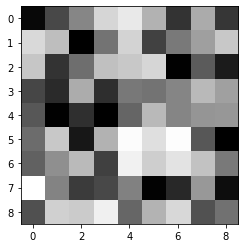

feature 2


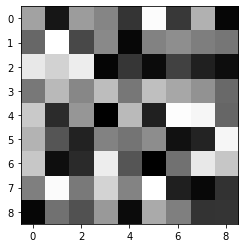

feature 3


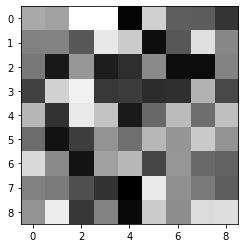

feature 4


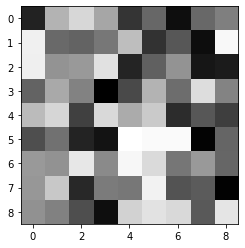

______________________
After extraction:
feature 1


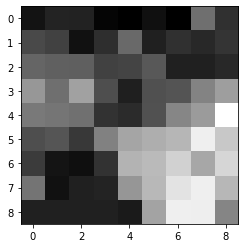

feature 2


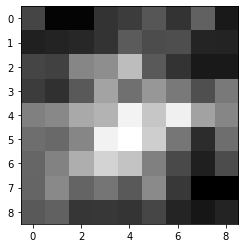

feature 3


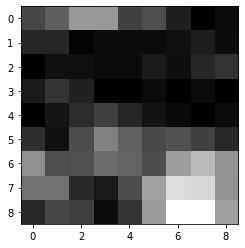

feature 4


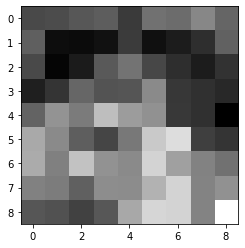

In [4]:
extract_features(4, 9, 0.05)

### Analysis of expriment 1

| Number Of Features | Features Size | Learning Rate |
| ------------------ | ------------- | ------------- |
|         4          |      9        |    0.05       |

As we can see as a result of K-Winners-Take-All and lateral inhibition each feature weights after extraction has changes in a way to extract a certain feature of the pictures.

### Experiment 2

Before extraction:
feature 1


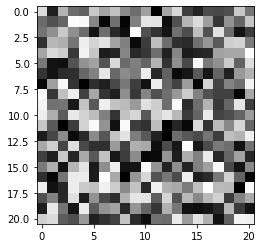

feature 2


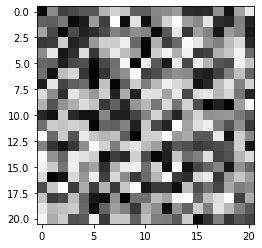

feature 3


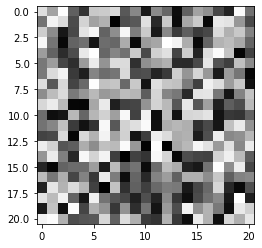

______________________
After extraction:
feature 1


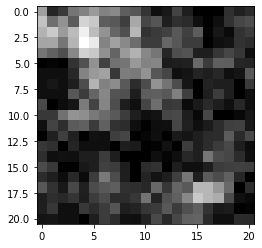

feature 2


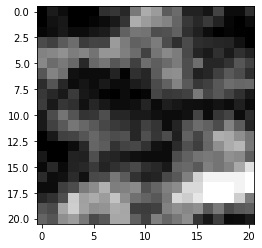

feature 3


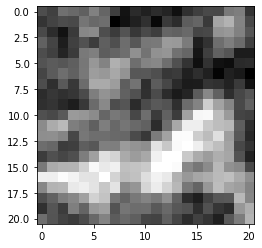

In [8]:
extract_features(3, 21, 0.05)

### Analysis of experiment 2

| Number Of Features | Features Size | Learning Rate |
| ------------------ | ------------- | ------------- |
|         3          |      21       |    0.05       |

Here we have much bigger features compared to previous experiment and we can see we have extracted diffrent features at this scale.

### Experiment 3

Before extraction:
feature 1


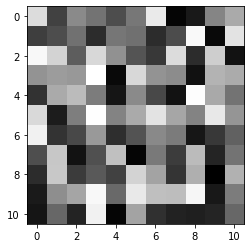

feature 2


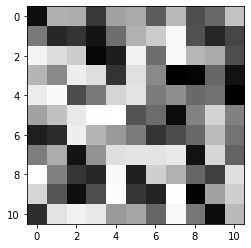

feature 3


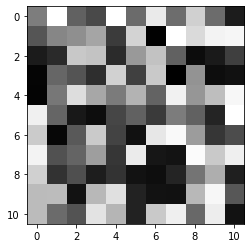

______________________
After extraction:
feature 1


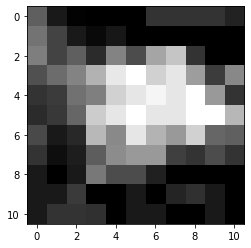

feature 2


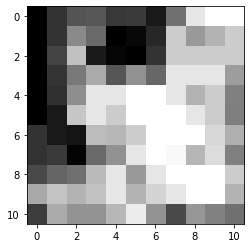

feature 3


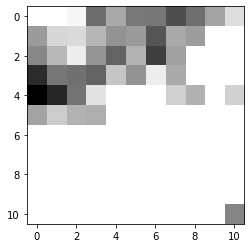

In [9]:
extract_features(3, 11, 0.1)

### Analysis of experiment 3

| Number Of Features | Features Size | Learning Rate |
| ------------------ | ------------- | ------------- |
|         3          |      11       |    0.1       |

Here we have a bigger learning rate so we can see that the feature weights will converge faster.

### Summary

In this project we have implemented K-Winners-Take-All and lateral inhibition mechanisms, these mechanisms will help us to extract diffrent features from our input, the K-Winners-Take-All will help to find important features and the lateral inhibition mechanism will help to choose diffrent features in each kernel, then with the help of STDP the kernel weights will converge to identify chosen features.